In [1]:
# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import datetime
from cryptocmd import CmcScraper

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Bitcoin colors
# ==============================================================================
palette_btc = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error


# Data download
# ==============================================================================

# Scraper is initialized, symbol, start and end of download are included
scraper = CmcScraper('BTC', '28-04-2013', '14-10-2022')

# Transform collected data into a dataframe
data = scraper.get_dataframe()
data.sort_values(by='Date', ascending=True, inplace=True)

pd.set_option('display.max_columns', None)
display(data)
pd.reset_option('display.max_columns')

# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
data = data.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')


C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


,Date,Open,High,Low,Close,Volume,Market Cap
3456,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3455,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3454,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3453,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3452,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2022-10-10,19446.416225,19515.467288,19102.979240,19141.483505,2.742502e+10,3.670492e+11
3,2022-10-11,19138.999877,19241.960236,18925.603222,19051.418269,2.871153e+10,3.653408e+11
2,2022-10-12,19052.645786,19203.198651,19029.758329,19157.446287,2.495017e+10,3.673914e+11
1,2022-10-13,19156.966613,19453.327971,18319.822630,19382.904034,4.421984e+10,3.717317e+11


Number of rows with missing values: 0.0


In [10]:
# Dict with Bitcoin halvings info
# ==============================================================================
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', 
                                         '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [11]:
# Next halving calculation
# The remaining blocks according to the coinmarketcap.com website for 
# the next halving as of 2022-01-14 are taken as a starting point
# ==============================================================================
remaining_blocks = 121400
blocks_per_day = 144

days = remaining_blocks / blocks_per_day

next_halving = pd.to_datetime('2022-10-14', format='%Y-%m-%d') + datetime.timedelta(days=days)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)
next_halving = next_halving.strftime('%Y-%m-%d')

btc_halving['date'][-1] = next_halving

print(f'The next halving will occur on approximately: {next_halving}')

The next halving will occur on approximately: 2025-02-03


In [12]:
# Include rewards and countdown to next halving in dataset
# ==============================================================================
data['reward'] = np.nan
data['countdown_halving'] = np.nan

for i in range(len(btc_halving['halving'])-1):
     
    # Start and end date of each halving
    if btc_halving['date'][i] < data.index.min().strftime('%Y-%m-%d'):
        start_date = data.index.min().strftime('%Y-%m-%d')
    else:
        start_date = btc_halving['date'][i]
        
    end_date = btc_halving['date'][i+1]
    mask = (data.index >= start_date) & (data.index < end_date)
        
    # Fill column 'reward' with mining rewards
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Fill column 'countdown_halving' with remaining days
    time_to_next_halving = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    
    data.loc[mask, 'countdown_halving'] = np.arange(time_to_next_halving.days)[::-1][:mask.sum()]

In [6]:
# Check that the data have been created correctly
# ==============================================================================
print('Second halving:', btc_halving['date'][2])
display(data.loc['2016-07-08':'2016-07-09'])
print('')
print('Third halving:', btc_halving['date'][3])
display(data.loc['2020-05-10':'2020-05-11'])
print('')
print('Next halving:', btc_halving['date'][4])
data.tail(2)

Second halving: 2016-07-09


,open,close,high,low,reward,countdown_halving
date,,,,,,
2016-07-08,640.687988,666.523010,666.706970,636.466980,25.0,0.0
2016-07-09,666.383972,650.960022,666.383972,633.398987,12.5,1401.0



Third halving: 2020-05-11


,open,close,high,low,reward,countdown_halving
date,,,,,,
2020-05-10,9591.169231,8756.431142,9595.580629,8395.107451,12.50,0.0
2020-05-11,8755.535639,8601.796202,9033.471176,8374.322975,6.25,1455.0



Next halving: 2024-05-06


,open,close,high,low,reward,countdown_halving
date,,,,,,
2022-10-13,19156.966613,19382.904034,19453.327971,18319.822630,6.25,570.0
2022-10-14,19382.533972,19185.656700,19889.146271,19115.407318,6.25,569.0


In [13]:
# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = data.index,
                  open  = data.open,
                  close = data.close,
                  low   = data.low,
                  high  = data.high,
              ) 

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Second halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Third halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Fourth halving')
                  ],
    xaxis_rangeslider_visible = False,
)

fig.show()

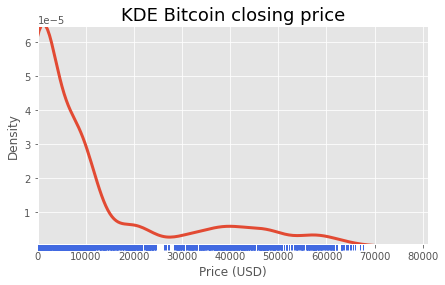

In [14]:
# KDE distribution of Bitcoin closing price
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
p = sns.kdeplot(data=data, x='close', linewidth=3, ax=ax)
r = sns.rugplot(data=data, x='close', ax=ax, c='royalblue',
                height=-.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title('KDE Bitcoin closing price', fontsize=18)
p.set_xlabel('Price (USD)');

In [15]:
# Locate corresponding data for each year
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = data.loc[data.index.year == year, 'open'][0]
    year_close = data.loc[data.index.year == year, 'close'][-1]
    year_low   = data.loc[data.index.year == year, 'low'].min()
    year_high  = data.loc[data.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2013,135.300003,754.010010,65.526001,1156.140015,457.287504
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526


In [16]:
# Create a list of dicts with the % change annotations for the plot
# ==============================================================================
annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x  = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y  = df_aux['high'].values[0]/max_high + 0.05
    text   = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)

# Interactive candlestick chart with Plotly
# ==============================================================================
candlestick = go.Candlestick(
                  x     = pd.to_datetime(df_plot.index, format='%Y'),
                  open  = df_plot.open,
                  close = df_plot.close,
                  low   = df_plot.low,
                  high  = df_plot.high
              )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Bitcoin/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
)

fig.show()

In [17]:
# Locate corresponding data for each month
# ==============================================================================
years = list(data.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (data.index >= start_date) & (data.index < end_date)
        
        if not data.loc[mask, :].empty:
                        
            month_open  = data.loc[mask, 'open'][0]
            month_close = data.loc[mask, 'close'][-1]
            month_low   = data.loc[mask, 'low'].min()
            month_high  = data.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

In [18]:
# Boxplot chart for annual seasonality
# ==============================================================================
# df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month
# fig, ax = plt.subplots(figsize=(7, 3.5))
# df_plot.boxplot(column='close', by='month', ax=ax)
# df_plot.groupby('month')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per month')
# fig.suptitle('');

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [19]:
# Boxplot chart for monthly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['day'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='close', by='day', ax=ax)
# data.groupby('day')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the month')
# fig.suptitle('');

data['day'] = pd.Series(data.index).dt.day.values

# fig 1 dayly boxplot
fig1 = px.box(data.sort_values('day'), x='day', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(data.groupby('day')['close'].median()).reset_index()
fig2 = px.line(df_median, x='day', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

In [20]:
# Boxplot chart for weekly seasonality
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['weekday'] = data.index.day_of_week + 1
# data.boxplot(column='close', by='weekday', ax=ax)
# data.groupby('weekday')['close'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('Price (USD)')
# ax.set_title('BTC Price per day of the week');

data['weekday'] = data.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(data.sort_values('weekday'), x='weekday', y='close',
              color_discrete_sequence=[palette_btc['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(data.groupby('weekday')['close'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='close', markers=True,
               color_discrete_sequence=[palette_btc['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>BTC Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
)

fig.show()

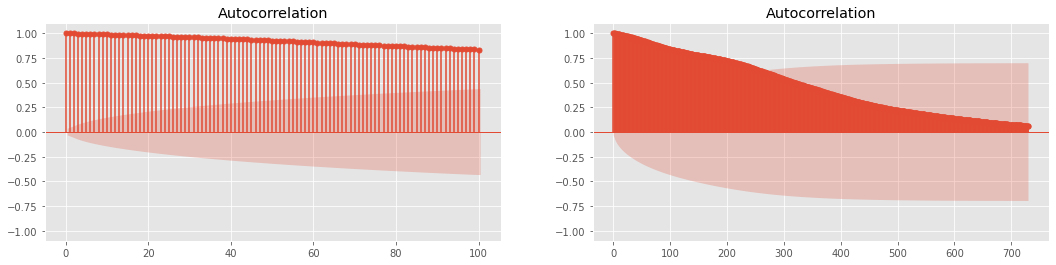

In [21]:
# Autocorrelation plot
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
axes = axes.flat
plot_acf(data.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(data.close, ax=axes[1], linewidth = 1, lags=730)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [22]:
# Selection of train-test dates
# ==============================================================================
start_train = '2020-01-01 00:00:00'
end_train = '2021-06-30 23:59:59'

print(f"Complete time series : {data.index.min()} --- {data.index.max()}  (n={len(data)})")
print(f"Train dates          : {data.loc[start_train:end_train].index.min()} --- {data.loc[start_train:end_train].index.max()}  (n={len(data.loc[start_train:end_train])})")
print(f"Test dates           : {data.loc[end_train:].index.min()} --- {data.loc[end_train:].index.max()}  (n={len(data.loc[end_train:])})")

Complete time series : 2013-04-28 00:00:00 --- 2022-10-14 00:00:00  (n=3457)
Train dates          : 2020-01-01 00:00:00 --- 2021-06-30 00:00:00  (n=547)
Test dates           : 2021-07-01 00:00:00 --- 2022-10-14 00:00:00  (n=471)


In [23]:
# Random walk simulation
# ==============================================================================
df_rw = data[['close']].copy()
df_rw['pred_close'] = df_rw['close'].shift(1)

# Test error
# ==============================================================================
y_true = df_rw.loc[end_train:, 'close']
y_pred = df_rw.loc[end_train:, 'pred_close']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].head(4))

Test error: 951.1023470739824


,close,pred_close
date,,
2021-07-01,33572.117653,35040.837249
2021-07-02,33897.048590,33572.117653
2021-07-03,34668.548402,33897.048590
2021-07-04,35287.779766,34668.548402


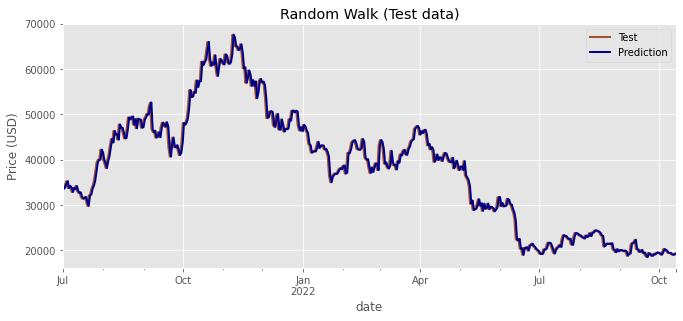

In [24]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
df_rw.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test',
                                    c='sienna')
df_rw.loc[end_train:, 'pred_close'].plot(ax=ax, linewidth=2, label='Prediction',
                                    c='darkblue')
ax.set_title('Random Walk (Test data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [25]:
# DataFrame models' test error
# ==============================================================================
df_errors = pd.DataFrame({'model': 'Base - Random Walk', 'lags': 1, 
                          'test_error': metric, 'exog_variables': False},
                         index=[0])
df_errors

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,951.102347,False


In [26]:
# Forecasters backtest with different lags
# ==============================================================================
lags = [1, 7, 30]
metrics = []
predictions_list = []

for lag in lags:
    
    # Create forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=123),
                     lags          = lag,
                     transformer_y = None
                 )
    
    # Backtest test data, 1 step
    metric, predictions = backtesting_forecaster(
                              forecaster         = forecaster,
                              y                  = data.loc[start_train:, 'close'],
                              initial_train_size = len(data.loc[start_train:end_train, 'close']),
                              fixed_train_size   = True,
                              steps              = 1,
                              refit              = True,
                              metric             = 'mean_absolute_error',
                              verbose            = False
                          )
    
    metrics.append(metric)
    predictions_list.append(predictions)

Forecaster will be fit 471 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 471 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 

Forecaster will be fit 471 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



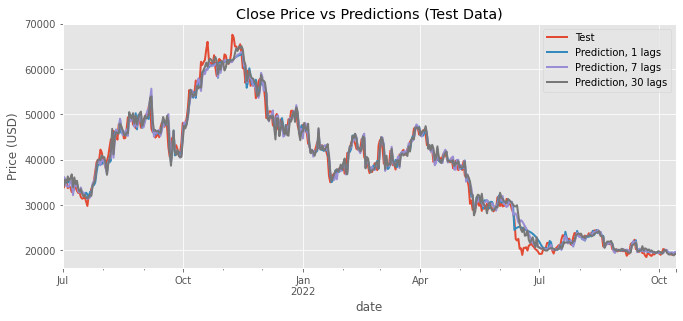

In [27]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot test predictions for different lags
for predictions, lag in zip(predictions_list, lags):
    predictions = predictions.rename(columns={'pred': f'Prediction, {lag} lags'})
    predictions.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [28]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': lags, 
                              'test_error': metrics, 'exog_variables': False})
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,951.102347,False
1,LGBMRegressor,1,1226.028693,False
2,LGBMRegressor,7,1272.833772,False
3,LGBMRegressor,30,1296.269496,False


In [29]:
# Change of the categorical variables to category type
# ==============================================================================
data['month'] = data.index.month
data['month'] = data['month'].astype('category')
data['reward'] = data['reward'].astype('category')

# One hot encoding
data = pd.get_dummies(data, columns=['reward', 'month'])
data.head(2)

,open,close,high,low,countdown_halving,day,weekday,reward_6.25,reward_12.5,reward_25.0,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,134.210007,135.979996,132.100006,1167.0,28,7,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2013-04-29,134.444000,144.539993,147.488007,134.000000,1166.0,29,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [30]:
# All exogenous variables are selected, including those obtained  
# during one hot encoding.
# ==============================================================================
exog = [column for column in data.columns if column.startswith(('reward', 'month'))]
exog.extend(['countdown_halving'])
print(exog)

['reward_6.25', 'reward_12.5', 'reward_25.0', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'countdown_halving']


In [31]:
# Forecaster backtest with exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )

# Backtest test data, 1 step
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.loc[start_train:, 'close'],
                          exog               = data.loc[start_train:, exog],
                          initial_train_size = len(data.loc[start_train:end_train, 'close']),
                          fixed_train_size   = True,
                          steps              = 1,
                          refit              = True,
                          metric             = 'mean_absolute_error',
                          verbose            = False
                      )

Forecaster will be fit 471 times. This can take substantial amounts of time. If not feasible, try with `refit = False`. 



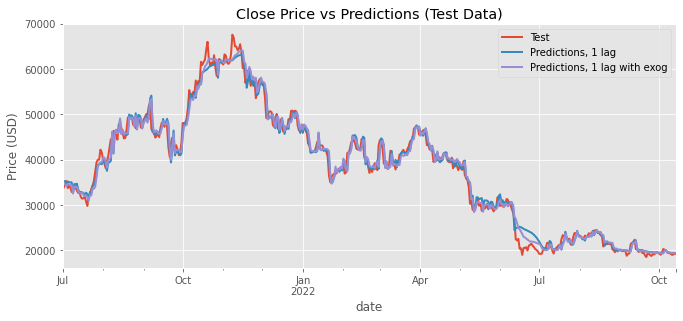

In [32]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4.5))
data.loc[end_train:, 'close'].plot(ax=ax, linewidth=2, label='Test')

# Plot predictions 1 lag without exogenous variables
predictions_no_exog = predictions_list[0].rename(columns={'pred': f'Predictions, 1 lag'})
predictions_no_exog.plot(ax=ax, linewidth=2)

# Plot predictions 1 lag with exogenous variables
predictions_exog = predictions.rename(columns={'pred': f'Predictions, 1 lag with exog'})
predictions_exog.plot(ax=ax, linewidth=2)

ax.set_title('Close Price vs Predictions (Test Data)')
ax.set_ylabel('Price (USD)')
ax.legend();

In [33]:
# DataFrame models' test error
# ==============================================================================
model = 'LGBMRegressor'

df_errors = pd.concat([
                df_errors,
                pd.DataFrame({'model': model, 'lags': 1, 
                              'test_error': metric, 'exog_variables': True},
                             index=[4])
                ]).reset_index(drop=True)

df_errors.sort_values(by='test_error')

,model,lags,test_error,exog_variables
0,Base - Random Walk,1,951.102347,False
4,LGBMRegressor,1,1154.512189,True
1,LGBMRegressor,1,1226.028693,False
2,LGBMRegressor,7,1272.833772,False
3,LGBMRegressor,30,1296.269496,False


In [34]:
import session_info
session_info.show(html=False)

ModuleNotFoundError: No module named 'session_info'

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

data = pd.read_csv("bitcoin_ticker.csv")

data.head()

data['rpt_key'].value_counts()

df = data.loc[(data['rpt_key'] == 'btc_usd')]
df.head()

df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2022-10-15 00:00:00')]

df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

df.head()

df = df[['last']]

dataset = df.values
dataset = dataset.astype('float32')

dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

trainX

trainY

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()


ModuleNotFoundError: No module named 'tensorflow.python.eager.polymorphic_function'